In [1]:
from tqdm import tqdm
from IPython.utils import io
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation

In [2]:
wb = pd.read_excel('Dataset/LSVT_voice_rehabilitation.xlsx', 'Data')
features = pd.DataFrame(wb)
wb = pd.read_excel('Dataset/LSVT_voice_rehabilitation.xlsx', 'Binary response')
class_label = pd.DataFrame(wb)
class1 = [float(i==1) for i in class_label.iloc[:,0]]
class2 = [float(i==2) for i in class_label.iloc[:,0]]
class_label = class_label.to_numpy().flatten()

In [3]:
for col in features.columns:
    features[col] = (features[col] - features[col].mean())/features[col].abs().max()
    
features

,Jitter->F0_abs_dif,Jitter->F0_dif_percent,Jitter->F0_PQ5_classical_Schoentgen,Jitter->F0_PQ5_classical_Baken,Jitter->F0_PQ5_generalised_Schoentgen,Jitter->F0_abs0th_perturb,Jitter->F0_CV,Jitter->F0_TKEO_mean,Jitter->F0_TKEO_std,Jitter->F0_TKEO_prc5,...,det_TKEO_std4_1_coef,det_TKEO_std4_2_coef,det_TKEO_std4_3_coef,det_TKEO_std4_4_coef,det_TKEO_std4_5_coef,det_TKEO_std4_6_coef,det_TKEO_std4_7_coef,det_TKEO_std4_8_coef,det_TKEO_std4_9_coef,det_TKEO_std4_10_coef
0,-0.066468,-0.082890,-0.082838,-0.033340,-0.061249,-0.020482,-0.020964,-0.038804,-0.034952,0.051697,...,0.007903,0.007720,0.007247,0.008839,0.008847,0.008944,0.007002,0.007106,0.007410,0.008703
1,-0.030866,-0.066103,-0.064835,0.067838,-0.081925,-0.019871,-0.020953,0.012543,0.063958,0.025804,...,0.098795,0.099252,0.098005,0.098818,0.099766,0.098824,0.098327,0.098659,0.099034,0.099850
2,0.158872,0.561317,0.566592,-0.000542,0.519678,0.026310,0.066991,-0.032220,-0.108107,-0.009437,...,-0.200743,-0.199414,-0.200822,-0.203238,-0.203230,-0.207259,-0.209097,-0.208821,-0.208217,-0.209700
3,-0.094019,-0.098523,-0.098027,0.005216,-0.080907,-0.028275,-0.021021,-0.075258,-0.112129,0.061130,...,-0.144775,-0.144617,-0.145622,-0.145107,-0.145004,-0.145269,-0.146545,-0.146343,-0.146087,-0.144950
4,-0.072234,-0.085704,-0.099164,0.308458,0.003853,-0.025916,-0.014811,-0.028485,-0.015284,0.057475,...,-0.013641,-0.011525,-0.016298,-0.013042,-0.013413,-0.013737,-0.015313,-0.015339,-0.014901,-0.014022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.052890,-0.051978,-0.050158,0.038097,-0.069764,-0.023081,-0.020920,-0.053079,-0.073146,0.046347,...,-0.051373,-0.050153,-0.049881,-0.048588,-0.048659,-0.049199,-0.048967,-0.049027,-0.048948,-0.048341
122,0.229291,0.230740,0.235550,0.099006,0.043501,-0.010882,-0.019039,0.024780,-0.017329,-0.092600,...,0.013112,0.015052,0.019401,0.020243,0.019213,0.018342,0.018686,0.017352,0.018778,0.018789
123,-0.073946,-0.073197,-0.072134,-0.050451,-0.060094,0.000215,-0.020981,-0.066567,-0.095212,0.056477,...,-0.089750,-0.089863,-0.091204,-0.091731,-0.091193,-0.091616,-0.092902,-0.092842,-0.092632,-0.090879
124,-0.055234,-0.069454,-0.067720,-0.009375,-0.075070,-0.022874,-0.020989,-0.037867,-0.034837,0.048065,...,0.011250,0.011519,0.010806,0.011183,0.011701,0.011451,0.011090,0.010679,0.010554,0.011329


In [4]:
classes = {'Acceptable': class1, 'Unacceptable': class2}
classes = pd.DataFrame(classes)
classes

,Acceptable,Unacceptable
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0
...,...,...
121,0.0,1.0
122,0.0,1.0
123,1.0,0.0
124,0.0,1.0


In [5]:
model = Sequential([
    
    InputLayer(input_shape=(features.shape[1])),
    
    Dense(7, activation='sigmoid'),
    
    Dense(5, activation='sigmoid'),
    
    Dense(2, activation='relu')
])

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

model.summary()

model.save_weights('model_weights/initial_weights_voice')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 2177      
                                                                 
 dense_1 (Dense)             (None, 5)                 40        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 2,229
Trainable params: 2,229
Non-trainable params: 0
_________________________________________________________________


In [6]:
acc = 0
j = 0
for train_index, test_index in KFold(10).split(features):
    x_train, x_test = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train, y_test = classes.iloc[train_index,:], classes.iloc[test_index,:]
    model.load_weights('model_weights/initial_weights_voice')
    with io.capture_output() as captured:
        model.fit(x_train, y_train, epochs=1000)
    acc += model.evaluate(x_test, y_test)[1]
    j+=1

1/1 [==============================] - 0s 22ms/step - loss: 7.7125 - accuracy: 0.3333


In [7]:
acc/j

0.3333333432674408

In [8]:
model.fit(features, classes, epochs=500)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 11/500
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 89/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 90/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 91/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 92/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 93/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 94/500
4/4 [===============

4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 168/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 169/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 170/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 171/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 172/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 173/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 174/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 175/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 176/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 177/500
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 250/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 251/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 252/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 253/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 254/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 255/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 256/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 257/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 258/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 259/500
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 332/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 333/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 334/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 335/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 336/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 337/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 338/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 339/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 340/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 341/500
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 414/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 415/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 416/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 417/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 418/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 419/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 420/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 421/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 422/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 423/500
4/4 [=====

4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 496/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 497/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 498/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 499/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7125 - accuracy: 0.3333
Epoch 500/500
4/4 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.3333


In [9]:
grad_sum = 0
for col_name in tqdm(features.columns):
    pointFrame = features.loc[:, features.columns != col_name]
    for i in features[col_name]:
        pointFrame[col_name] = i*np.ones(len(features.index))
        points = tf.Variable(pointFrame, dtype='float')
        with tf.GradientTape() as tape:
            pred = model(points, training=False)
        grads = tape.gradient(pred, points)
        grad_sum += np.abs(grads.numpy())
saliency_order = np.argsort(np.sum(np.abs(grad_sum),0))

100%|██████████| 310/310 [02:20<00:00,  2.20it/s]


[]

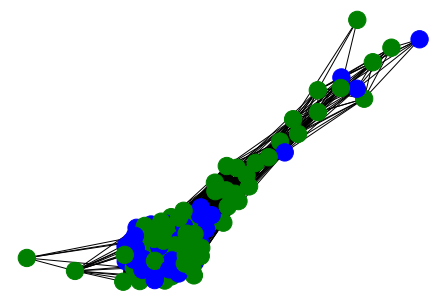

In [10]:
num_features = 35

salient_features = features.iloc[:,saliency_order[0:num_features]]
A = np.zeros((features.shape[0], features.shape[0]))
for i in features.index:
    for j in range(i):
        A[i,j] = np.linalg.norm(salient_features.iloc[i,:] - salient_features.iloc[j,:])
A = A + np.transpose(A)
# print(A)
# p = np.median(A).astype('int')
p = 0.5
A = (A <= p)
A = A - np.eye(A.shape[0])
rows, cols = np.where(A==1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges, node_size=1)
color_map = np.array([])
acceptable = np.array([])
unacceptable = np.array([])
for node in G:
    if (class_label[node]==1):
        acceptable = np.append(acceptable, node)
        color_map = np.append(color_map, 'blue')
    else:
        unacceptable = np.append(unacceptable, node)
        color_map = np.append(color_map, 'green')
nx.draw(G, node_color=color_map)
plt.plot()

In [11]:
nx.is_connected(G) # tells whether or not the graph is connected
# nx.clustering(G) # gives the clustering value of each vertex

True

In [12]:
nx.number_connected_components(G) # number of different connected components

1

In [13]:
nx.density(G) # this tells how close the graph is to being fully connected

0.6147058823529412

In [14]:
nx.average_clustering(G) # clustering value for the whole graph

0.8806634782256001

In [15]:
nx.transitivity(G) # 3* number of triangles in G/ number of connected triads in G

0.8982827455246436

[]

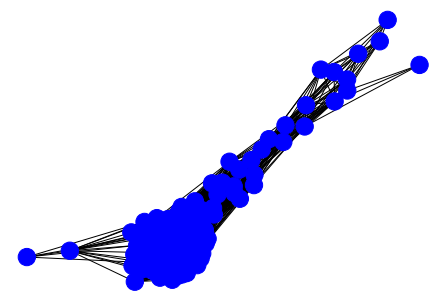

In [16]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in G:
    if node in giant_component:
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'red')
nx.draw(G, node_color=color_map_GC)
plt.plot()

In [17]:
nx.eccentricity(giant_component) # largest possible shortest path distance between a vertex and all other vertices

{0: 4,
 1: 3,
 3: 4,
 4: 4,
 5: 4,
 6: 4,
 7: 4,
 8: 4,
 9: 4,
 12: 4,
 14: 4,
 15: 4,
 17: 3,
 18: 4,
 19: 4,
 20: 3,
 21: 4,
 22: 3,
 23: 4,
 24: 4,
 25: 3,
 27: 4,
 28: 3,
 29: 4,
 30: 4,
 31: 4,
 32: 4,
 33: 4,
 34: 3,
 35: 3,
 36: 4,
 37: 3,
 38: 4,
 39: 4,
 40: 3,
 41: 4,
 42: 4,
 45: 4,
 46: 3,
 48: 3,
 52: 4,
 55: 4,
 56: 5,
 57: 3,
 60: 3,
 64: 4,
 67: 4,
 69: 4,
 70: 4,
 71: 4,
 72: 4,
 73: 4,
 74: 3,
 75: 4,
 76: 4,
 77: 4,
 78: 4,
 79: 5,
 81: 3,
 84: 4,
 85: 3,
 87: 4,
 88: 4,
 89: 4,
 90: 4,
 91: 4,
 92: 4,
 93: 4,
 94: 4,
 95: 4,
 96: 4,
 97: 3,
 99: 4,
 100: 4,
 101: 4,
 102: 4,
 103: 4,
 105: 4,
 106: 4,
 108: 4,
 109: 4,
 110: 4,
 111: 4,
 112: 4,
 113: 4,
 114: 4,
 115: 4,
 116: 4,
 117: 4,
 118: 4,
 119: 4,
 120: 4,
 121: 4,
 122: 4,
 123: 4,
 124: 4,
 125: 4,
 11: 3,
 13: 3,
 16: 3,
 47: 3,
 49: 3,
 50: 3,
 54: 3,
 61: 3,
 82: 3,
 83: 3,
 2: 5,
 62: 5,
 10: 4,
 43: 4,
 51: 4,
 53: 5,
 58: 4,
 63: 4,
 65: 4,
 66: 5,
 80: 4,
 26: 4,
 107: 5}

In [18]:
nx.diameter(giant_component) # maximum shortest distance between a pair of vertices in G, it is the largest possible eccentricity value of a vertex

5

In [19]:
nx.radius(giant_component) #  minimum eccentricity value of a vertex

3

In [20]:
# below gives us the different centrality measures for the vertices of the graphs
nx.degree_centrality(G)

{0: 0.8067226890756303,
 1: 0.40336134453781514,
 3: 0.6470588235294117,
 4: 0.7731092436974789,
 5: 0.7647058823529411,
 6: 0.7142857142857143,
 7: 0.5714285714285714,
 8: 0.7647058823529411,
 9: 0.8151260504201681,
 12: 0.7647058823529411,
 14: 0.5630252100840336,
 15: 0.7394957983193277,
 17: 0.7310924369747899,
 18: 0.7647058823529411,
 19: 0.8319327731092436,
 20: 0.7058823529411764,
 21: 0.8067226890756303,
 22: 0.38655462184873945,
 23: 0.8067226890756303,
 24: 0.8151260504201681,
 25: 0.5798319327731092,
 27: 0.7394957983193277,
 28: 0.8319327731092436,
 29: 0.7394957983193277,
 30: 0.6554621848739496,
 31: 0.7647058823529411,
 32: 0.7647058823529411,
 33: 0.8067226890756303,
 34: 0.37815126050420167,
 35: 0.7058823529411764,
 36: 0.7647058823529411,
 37: 0.36974789915966383,
 38: 0.8067226890756303,
 39: 0.7647058823529411,
 40: 0.6890756302521008,
 41: 0.7731092436974789,
 42: 0.7731092436974789,
 45: 0.7731092436974789,
 46: 0.4369747899159664,
 48: 0.7226890756302521,
 52: 

In [22]:
max(nx.degree_centrality(G))

125

In [23]:
nx.eigenvector_centrality(G)

{0: 0.1107249596354583,
 1: 0.0437556500089303,
 3: 0.09424016456294924,
 4: 0.10919336957428247,
 5: 0.10862144036494677,
 6: 0.10288868854807402,
 7: 0.08434434510839416,
 8: 0.10862144036494677,
 9: 0.11102482693455229,
 12: 0.10862144036494677,
 14: 0.08343382878398833,
 15: 0.10590115003377322,
 17: 0.09594945765984532,
 18: 0.10862144036494677,
 19: 0.11078549178057068,
 20: 0.09270789767999092,
 21: 0.1107249596354583,
 22: 0.04135728857226254,
 23: 0.11081384473723788,
 24: 0.11102482693455229,
 25: 0.07229005641569464,
 27: 0.10590115003377322,
 28: 0.10994804546096706,
 29: 0.10590115003377322,
 30: 0.09520576783665359,
 31: 0.10862144036494677,
 32: 0.10862144036494677,
 33: 0.1107249596354583,
 34: 0.040110825178980056,
 35: 0.09270789767999092,
 36: 0.10862144036494677,
 37: 0.038842183470265565,
 38: 0.1107249596354583,
 39: 0.10862144036494677,
 40: 0.08924859739136715,
 41: 0.10880824684133335,
 42: 0.10803800146647839,
 45: 0.10919336957428247,
 46: 0.04995553812444942

In [24]:
max(nx.eigenvector_centrality(G))

125

In [25]:
nx.closeness_centrality(G)

{0: 0.7727272727272727,
 1: 0.6197916666666666,
 3: 0.6502732240437158,
 4: 0.74375,
 5: 0.7300613496932515,
 6: 0.695906432748538,
 7: 0.6197916666666666,
 8: 0.7300613496932515,
 9: 0.7880794701986755,
 12: 0.7300613496932515,
 14: 0.6296296296296297,
 15: 0.7125748502994012,
 17: 0.7677419354838709,
 18: 0.7300613496932515,
 19: 0.8040540540540541,
 20: 0.7531645569620253,
 21: 0.7727272727272727,
 22: 0.6102564102564103,
 23: 0.7727272727272727,
 24: 0.7880794701986755,
 25: 0.6878612716763006,
 27: 0.7125748502994012,
 28: 0.815068493150685,
 29: 0.7125748502994012,
 30: 0.6538461538461539,
 31: 0.7300613496932515,
 32: 0.7300613496932515,
 33: 0.7727272727272727,
 34: 0.6071428571428571,
 35: 0.7531645569620253,
 36: 0.7300613496932515,
 37: 0.5979899497487438,
 38: 0.7727272727272727,
 39: 0.7300613496932515,
 40: 0.74375,
 41: 0.7345679012345679,
 42: 0.7345679012345679,
 45: 0.74375,
 46: 0.6296296296296297,
 48: 0.7628205128205128,
 52: 0.7300613496932515,
 55: 0.734567901234

In [27]:
max(nx.closeness_centrality(G))

125

In [28]:
nx.betweenness_centrality(G)

{0: 0.0037720293631446924,
 1: 0.012921040885430552,
 3: 9.023608959315774e-05,
 4: 0.0013444223439621668,
 5: 0.0009703254426961411,
 6: 0.0004030980342976736,
 7: 1.5410141561538116e-05,
 8: 0.0009703254426961411,
 9: 0.0051519799907136996,
 12: 0.0009703254426961411,
 14: 2.1279160995696813e-05,
 15: 0.0005972951574331342,
 17: 0.012478959002474532,
 18: 0.0009703254426961411,
 19: 0.009839259719400565,
 20: 0.010501308655631479,
 21: 0.0037720293631446924,
 22: 0.010721540511069192,
 23: 0.0053433717178943034,
 24: 0.0051519799907136996,
 25: 0.012624362393886163,
 27: 0.0005972951574331342,
 28: 0.014212221554659912,
 29: 0.0005972951574331342,
 30: 0.00011481389774225742,
 31: 0.0009703254426961411,
 32: 0.0009703254426961411,
 33: 0.0037720293631446924,
 34: 0.009788866989568214,
 35: 0.010501308655631479,
 36: 0.0009703254426961411,
 37: 0.008999040908152713,
 38: 0.0037720293631446924,
 39: 0.0009703254426961411,
 40: 0.014174953808700892,
 41: 0.0020601646168735025,
 42: 0.00

In [29]:
max(nx.betweenness_centrality(G))

125

In [30]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(salient_features)
predicted_label = kmeans.labels_
print('Number of Iterations: ', kmeans.n_iter_)

Number of Iterations:  6


In [31]:
print('Cluster Centers: ', kmeans.cluster_centers_)

Cluster Centers:  [[-2.79345562e-02 -4.72571677e-02 -4.65362966e-02 -5.29601555e-02
  -5.45150807e-02 -4.81829380e-02 -3.39416975e-02 -2.92395137e-02
  -2.99294516e-02 -3.02394898e-02 -3.15888537e-02 -3.31857678e-02
  -3.29046509e-02 -8.57948678e-03 -8.47661842e-03 -7.41541361e-03
  -4.62569006e-02 -7.31861214e-03 -4.32734597e-02 -4.18833286e-02
  -1.50253798e-02 -1.37740029e-02 -1.32958722e-02 -1.07243285e-02
  -1.69509610e-02 -1.35177916e-02 -1.83515596e-02 -1.86331202e-02
  -1.46502635e-02 -1.67201739e-02  9.32242297e-05 -5.39939387e-02
  -4.37232906e-02 -5.24404456e-02 -4.41249411e-02]
 [ 1.57315658e-01  2.66132471e-01  2.62072828e-01  2.98249297e-01
   3.07005981e-01  2.71346019e-01  1.91145349e-01  1.64664630e-01
   1.68550070e-01  1.70296074e-01  1.77895124e-01  1.86888271e-01
   1.85305139e-01  4.83160571e-02  4.77367458e-02  4.17604872e-02
   2.60499388e-01  4.12153420e-02  2.43697905e-01  2.35869271e-01
   8.46166126e-02  7.75693849e-02  7.48767537e-02  6.03949028e-02
   9.54

In [32]:
print('Inertia: ', kmeans.inertia_) # SSE

Inertia:  37.32784441184974


In [33]:
compared_classes = class_label - 1
print('KMeans accuracy: ', np.count_nonzero(compared_classes!=predicted_label)/ len(predicted_label))

KMeans accuracy:  0.5793650793650794


[]

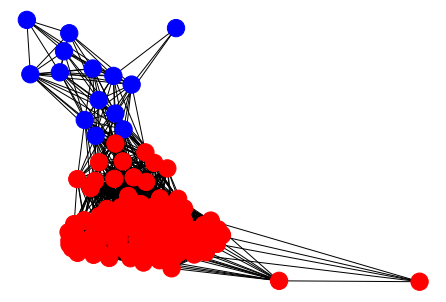

In [34]:
color_map_cluster = np.array([])
for node in G:
    if (predicted_label[node]==0):
        color_map_cluster = np.append(color_map_cluster, 'red')
    else:
        color_map_cluster = np.append(color_map_cluster, 'blue')
nx.draw(G, node_color=color_map_cluster)
plt.plot()